In [1]:
import tensorflow as tf
with tf.device('/device:GPU:3'):
    import pickle as pk
    import numpy as np
    import keras
    from keras.models import Sequential
    #from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose,Activation
    from keras.layers.normalization import BatchNormalization
    from keras import backend as K
    epochs = 10
    batch_size = 32
    pickle_train = open("noiseBabble_20db.pickle","rb")
    x_train = pk.load(pickle_train)
    pickle_trainlabel = open("cleanBabble.pickle","rb")
    y_train = pk.load(pickle_trainlabel)

    print("Got the input data")
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    print(np.asarray(x_train).shape)
    #     print(x_train[0:10].shape)
    X_train = []
    #X_train = np.asarray(X_train)
    for i in range(7,len(x_train)):
        temp = x_train[i-7]
        for j in range(1,8):
            temp = np.concatenate((temp,x_train[(i-7)+j]),axis=1)
        X_train.append(temp)
        #X_train.append(x_train[i-8:i,:].reshape(129,128))

    X_train = np.asarray(X_train)
    print("H",np.asarray(X_train).shape)
    X_train = X_train.reshape(X_train.shape[0], 129, 128, 1)
    print("H2",np.asarray(X_train).shape)
    y_train = y_train.reshape(y_train.shape[0], 129, 16, 1)

    model = Sequential()
    model.add(Conv2D(64, kernel_size=(7, 7),strides=(1, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',input_shape=(129,128,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (5, 5),strides=(1, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (1, 1),strides=(1, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    #model.add(Conv2DTranspose(128, (3, 3), activation='relu',padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(128, (3, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(64, (5, 5),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(1, (7, 7),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
                  metrics=['accuracy'])
    #model.build()

    print(model.summary())
    with tf.device('/device:GPU:2') as open:
        model.fit(np.asarray(X_train), np.asarray(y_train[7:]),
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split = 0.01
                 )

    model.save_weights('weights_8frames_10.h5')
    model.save('model_8frames_10.h5')

Using TensorFlow backend.


Got the input data
(256788, 129, 16)
H (256781, 129, 128)
H2 (256781, 129, 128, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 123, 41, 64)       3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 123, 41, 64)       256       
_________________________________________________________________
activation_1 (Activation)    (None, 123, 41, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 119, 13, 128)      204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 119, 13, 128)      512       
_________________________________________________________________
activation_2 (Activation)    (None, 119, 13, 128)      0         
___________________________________________________________

In [2]:
from keras.models import load_model
new_model = load_model('model_8frames_10.h5')

In [5]:
from scipy import signal
from scipy.io import wavfile
import numpy as np
sample_rate, samples = wavfile.read('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/Noisy_TCDTIMIT/Babble/20/volunteers/01M/straightcam/sa1.wav')
print(sample_rate)
print(len(samples))
print(samples.shape)
#samples = samples.reshape(samples.shape[0])
#samples = samples[:,1]
print((samples).shape)
NoiseBabble= []
Phase = []
f, t, Zxx = signal.stft(samples, sample_rate,nperseg=256,nfft=256)
print("Z",Zxx.shape)
phase = np.angle(Zxx)
T = len(t)//16
print("T",T)
for i in range(0,(T)*16,16):
  NoiseBabble.append(np.log(np.abs(Zxx[:,i:i+16])+1e-8))
  Phase.append(phase[:,i:i+16])
print("N",np.asarray(NoiseBabble).shape)
# if len(t) % 16 !=0:
#   NoiseBabble.append(np.log(np.abs(Zxx[:,len(t)-16:len(t)])+1e-8))
#   Phase.append(phase[:,len(t)-16:len(t)])
#   T = T+1
X_NoiseBabble = []
NoiseBabble = np.asarray(NoiseBabble)
print("S",NoiseBabble.shape)
for i in range(0,7):
    temp = NoiseBabble[0]
    for j in range(1,8):
        temp = np.concatenate((temp,NoiseBabble[j]),axis=1)
        #print("tempshape",temp.shape)
    X_NoiseBabble.append(temp)
    #X_NoiseBabble = np.append(X_NoiseBabble,NoiseBabble[0:8],axis=1)
for i in range(7,len(NoiseBabble)):
    temp = NoiseBabble[i-7]
    for j in range(1,8):
        temp = np.concatenate((temp,NoiseBabble[(i-7)+j]),axis=1)
    X_NoiseBabble.append(temp)
    #X_NoiseBabble.append(NoiseBabble[i-8:i,:,:].reshape(129,128))
print("H1",np.asarray(X_NoiseBabble).shape)
b = np.asarray(X_NoiseBabble)
X_NoiseBabble = b.reshape(b.shape[0], 129, 128, 1)
rectified = new_model.predict(X_NoiseBabble)
rectified =rectified.reshape(rectified.shape[0], 129, 16)
print("R",rectified.shape)
A = np.zeros((129,0))
for i in range(T):
  S = np.exp(rectified[i])
  A = np.append(A,S*np.cos(Phase[i]) + 1j * S*np.sin(Phase[i]),axis=1)
t,x = signal.istft(A,nperseg=256,nfft=256)
x = np.asarray(x, dtype=np.int16)
#print(len(x))
#data=np.int16(x/np.max(np.abs(x)) * 32767)
wavfile.write('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/code/babble/testing/frames_sa1.wav', 16000, x)

16000
82944
(82944,)
(82944,)
Z (129, 649)
T 40
N (40, 129, 16)
S (40, 129, 16)
H1 (40, 129, 128)


ResourceExhaustedError: OOM when allocating tensor with shape[32,256,117,11] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_3_1/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_2_1/Relu, conv2d_3_1/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [1]:
import pickle as pk
import tensorflow as tf
import numpy as np
with tf.device('/device:GPU:2'):
    import keras
    from keras.models import Sequential
    #from keras.layers import Dense, Dropout, Flatten
    from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose,Activation
    from keras.layers.normalization import BatchNormalization
    from keras import backend as K
    epochs = 10
    batch_size = 64
    pickle_train = open("noiseBabble_20db.pickle","rb")
    x_train = pk.load(pickle_train)
    pickle_trainlabel = open("cleanBabble.pickle","rb")
    y_train = pk.load(pickle_trainlabel)

    print("Got the input data")
    #x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    print(np.asarray(x_train).shape)
    #     print(x_train[0:10].shape)
    X_train = []
    #X_train = np.asarray(X_train)
    for i in range(7,len(x_train)):
        X_train.append(x_train[i-7:i+1])
    #     temp = x_train[i-7]
    #     for j in range(1,8):
    #         temp = np.concatenate((temp,x_train[(i-7)+j]),axis=1)
    #     X_train.append(temp)

    X_train = np.asarray(X_train)
    print("H",np.asarray(X_train).shape)
    # X_train = X_train.reshape(X_train.shape[0], 129, 128, 1)
    # print("H2",np.asarray(X_train).shape)
    y_train = y_train.reshape(y_train.shape[0],1,129, 16)
    
    
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(7, 7),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first",input_shape=(8,129,16)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, (5, 5),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (3, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(256, (1, 1),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first"))
    #model.add(Conv2DTranspose(128, (3, 3), activation='relu',padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(128, (3, 3),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(64, (5, 5),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2DTranspose(1, (7, 7),padding='valid',use_bias=True, kernel_initializer='glorot_uniform',bias_initializer='zeros',data_format= "channels_first"))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.compile(loss=keras.losses.mean_squared_error,
                  optimizer=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999),
                  metrics=['accuracy'])
    #model.build()
#     def ATH():
#         return 3.64*(pow(f/1000,0.8)) - 6.5*(np.exp(0.6*(pow(f/1000-3.3,2)))) + 0.001*(pow(f/1000,4))

#     def myloss(y_true,y_pred,weights):
#         return np.mean((weights(y_true-y_pred))**2)

    print(model.summary())
    with tf.device('/device:GPU:2') as open:
        model.fit(np.asarray(X_train), np.asarray(y_train[7:]),
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split = 0.01
                 )

    model.save_weights('weights_8frames_10_final.h5')
    model.save('model_8frames_10_final.h5')

Using TensorFlow backend.


Got the input data
(256788, 129, 16)
H (256781, 8, 129, 16)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 123, 10)       25152     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 123, 10)       40        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 123, 10)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 119, 6)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 119, 6)       24        
_________________________________________________________________
activation_2 (Activation)    (None, 128, 119, 6)       0         
_________________________________________________________________
conv2d_3 (Conv2D

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



254213/254213 [==============================] - 233s 918us/step - loss: 5.5817 - acc: 0.2159 - val_loss: 5.1614 - val_acc: 0.2251
Epoch 4/10
 48768/254213 [====>.........................] - ETA: 3:02 - loss: 5.5111 - acc: 0.2317

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



244096/254213 [===========================>..] - ETA: 9s - loss: 5.5479 - acc: 0.2640

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



254213/254213 [==============================] - 234s 919us/step - loss: 5.5340 - acc: 0.2926 - val_loss: 5.1837 - val_acc: 0.2632
Epoch 8/10
254213/254213 [==============================] - 229s 901us/step - loss: 5.5285 - acc: 0.3020 - val_loss: 5.1281 - val_acc: 0.2868
Epoch 9/10
254213/254213 [==============================] - 233s 915us/step - loss: 5.5255 - acc: 0.3074 - val_loss: 5.1404 - val_acc: 0.2873
Epoch 10/10
254213/254213 [==============================] - 229s 900us/step - loss: 5.5225 - acc: 0.3114 - val_loss: 5.1340 - val_acc: 0.3012


In [1]:
from keras.models import load_model
new_model = load_model('model_8frames_10_final.h5')

Using TensorFlow backend.


In [10]:
from scipy import signal
from scipy.io import wavfile
import numpy as np
sample_rate, samples = wavfile.read('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/Noisy_TCDTIMIT/Babble/20/.wav')
print(sample_rate)
print(len(samples))
print(samples.shape)
#samples = samples.reshape(samples.shape[0])
#samples = samples[:,1]
print((samples).shape)
NoiseBabble= []
Phase = []
f, t, Zxx = signal.stft(samples, sample_rate,nperseg=256,nfft=256)
print("Z",Zxx.shape)
phase = np.angle(Zxx)
T = len(t)//16
print("T",T)
for i in range(0,(T)*16,16):
  NoiseBabble.append(np.log(np.abs(Zxx[:,i:i+16])+1e-8))
  Phase.append(phase[:,i:i+16])
print("N",np.asarray(NoiseBabble).shape)
# if len(t) % 16 !=0:
#   NoiseBabble.append(np.log(np.abs(Zxx[:,len(t)-16:len(t)])+1e-8))
#   Phase.append(phase[:,len(t)-16:len(t)])
#   T = T+1
X_NoiseBabble = []
NoiseBabble = np.asarray(NoiseBabble)
print("S",NoiseBabble.shape)
for i in range(0,7):
#     temp = NoiseBabble[0]
#     for j in range(1,8):
#         temp = np.concatenate((temp,NoiseBabble[j]),axis=1)
#         #print("tempshape",temp.shape)
#     X_NoiseBabble.append(temp)
    X_NoiseBabble.append(NoiseBabble[0:8])
for i in range(7,len(NoiseBabble)):
#     temp = NoiseBabble[i-7]
#     for j in range(1,8):
#         temp = np.concatenate((temp,NoiseBabble[(i-7)+j]),axis=1)
#     X_NoiseBabble.append(temp)
    X_NoiseBabble.append(NoiseBabble[i-7:i+1])
print("H1",np.asarray(X_NoiseBabble).shape)
b = np.asarray(X_NoiseBabble)
#X_NoiseBabble = b.reshape(b.shape[0],8, 129, 16)
rectified = new_model.predict(b)
print(rectified.shape)
rectified =rectified.reshape(rectified.shape[0], 129, 16)
print(rectified.shape)
A = np.zeros((129,0))
for i in range(T):
  S = np.exp(rectified[i])
  A = np.append(A,S*np.cos(Phase[i]) + 1j * S*np.sin(Phase[i]),axis=1)
t,x = signal.istft(A,nperseg=256,nfft=256)
x = np.asarray(x, dtype=np.int16)
#print(len(x))
#data=np.int16(x/np.max(np.abs(x)) * 32767)
wavfile.write('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/code/babble/testing/frames_si1021.wav', 16000, x)

16000
126293
(126293,)
(126293,)
Z (129, 988)
T 61
N (61, 129, 16)
S (61, 129, 16)
H1 (61, 8, 129, 16)
(61, 1, 129, 16)
(61, 129, 16)


In [3]:
import matplotlib.pyplot as plt
from scipy.fftpack import fft
from scipy.io import wavfile
import numpy as np
fs, data = wavfile.read('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/code/babble/testing/frames_sa1.wav')
fft_out = fft(data)
print(len(data))
plt.plot(np.arange(0,len(fft_out)), np.abs(fft_out))
plt.show()



81792


<Figure size 640x480 with 1 Axes>

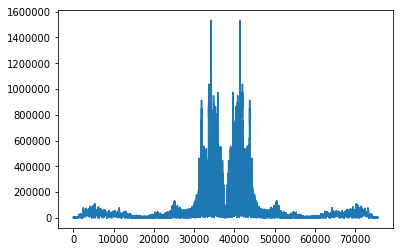

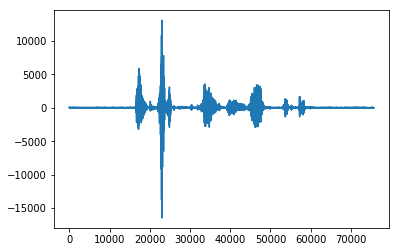

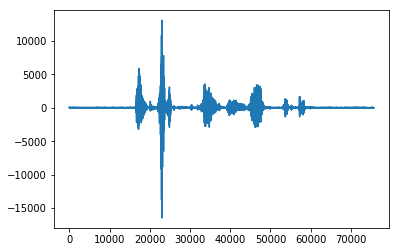

In [18]:
fs, data = wavfile.read('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/code/babble/testing/frames_sa2.wav')
fft_out = (fft(data))
FFT = np.fft.fftshift(fft_out)
plt.plot(np.arange(0,data.shape[0]), np.abs(FFT))
plt.show()
plt.plot(np.arange(0,data.shape[0]),data)
plt.show()

plt.plot(np.arange(0,data.shape[0]),np.fft.ifft(fft_out))
plt.show()

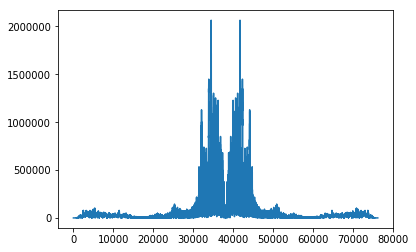

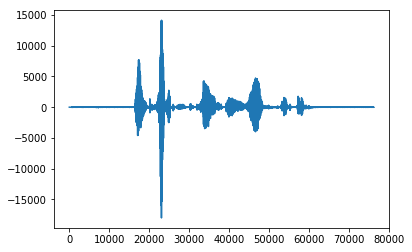

In [11]:
fs, data = wavfile.read('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/Clean/volunteers/01M/straightcam/sa2.wav')
fft_out = np.fft.fftshift(fft(data))
plt.plot(np.arange(0,data.shape[0]), np.abs(fft_out))
plt.show()
plt.plot(np.arange(0,data.shape[0]),data)
plt.show()

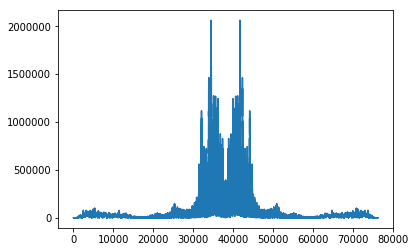

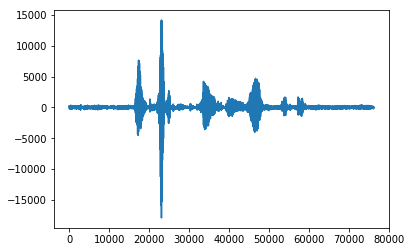

In [12]:

fs, data = wavfile.read('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/Noisy_TCDTIMIT/Babble/20/volunteers/01M/straightcam/sa2.wav')
fft_out = np.fft.fftshift(fft(data))
plt.plot(np.arange(0,data.shape[0]), np.abs(fft_out))
plt.show()
plt.plot(np.arange(0,data.shape[0]),data)
plt.show()

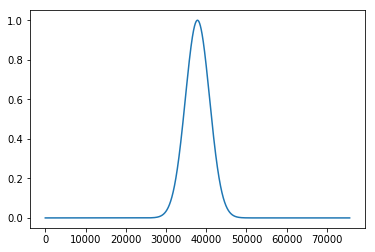

In [21]:
import scipy.ndimage
from scipy import signal
window = signal.gaussian(data.shape[0], std=3000,sym=True)
plt.plot(window)
plt.show()

In [19]:
data.shape

(75648,)

In [22]:
D = (window)*np.abs(FFT)
phase = np.angle(fft_out)
D = np.fft.ifftshift(D) *(np.cos(phase) + 1j*np.sin(phase))


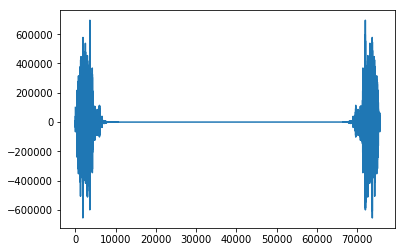

In [23]:
plt.plot(np.arange(0,data.shape[0]),D)
plt.show()

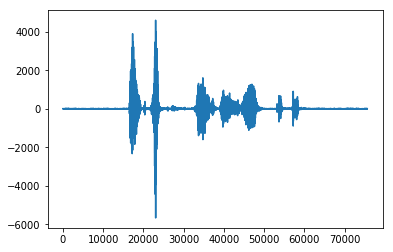

In [24]:
e = np.fft.ifft(D)
plt.plot(np.arange(0,len(e)),e)
plt.show()


In [25]:
x = np.asarray(e, dtype=np.int16)
wavfile.write('/media/hd2/chaitanya/Deep_Learning/project/TCDTIMIT/code/babble/testing/jeeva.wav', 16000, x)

In [17]:
FFT.shape

(75648,)